In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import gc
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd
import s2_py as s2
from shapely.geometry import Polygon, mapping, box

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ca_df = gpd.read_file("../Data/Processed/CA_S2Cells/CA_S2Cells.shp")
ca_df = ca_df.to_crs({'init': 'epsg:4326'})
ca_df.rename(columns={'S2_Cells_I': 'S2_Cells_ID'}, inplace=True)
ca_df.shape

(10643, 9)

In [5]:
ca_wf = pd.read_csv('../Data/Processed/WildFire_S2Cells.csv')
ca_wf.shape

(3673, 46)

In [6]:
ca_wf.head()

,S2_Cells_ID,WF_ALARM_DATE_DT_DT,WF_WildFire_COUNT,WF_YEAR,WF_ALARM_DATE_MONTH,WF_WildFire,WF_GIS_ACRES,WF_Shape_Length,WF_Shape_Area,WF_FIRE_DUR,...,WF_C_METHOD_4,WF_C_METHOD_5,WF_C_METHOD_6,WF_C_METHOD_7,WF_C_METHOD_8,WF_WildFire_COUNT_1YR_AGO,WF_WildFire_COUNT_2YR_AGO,WF_WildFire_COUNT_3YR_AGO,WF_WildFire_COUNT_4YR_AGO,WF_WildFire_COUNT_5YR_AGO
0,54c942c,2017-07-24,1,2017,7,1,1492.397827,19322.129952,6.039520e+06,129.0,...,0,0,0,0,0,0,0,0,0,0
1,54c94c,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0
2,54c94d4,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0
3,54c94dc,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0
4,54c9524,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
def bin_probs(probs):
    perc = {
        'low': 10,
        'low-med': 30,
        'med-high': 70,
        'high': 90} 
    perc_cuts = {}
    for p in perc:
        perc_cuts[p] = np.percentile(probs, perc[p])
    
    conditions = [
        (probs <= perc_cuts['low']),
        ((probs > perc_cuts['low']) & (probs <= perc_cuts['low-med'])),
        ((probs > perc_cuts['low-med']) & (probs <= perc_cuts['med-high'])),
        ((probs > perc_cuts['med-high']) & (probs <= perc_cuts['high'])),
        (probs > perc_cuts['high'])
    ]
    choices = ['1. low', '2. low-med', '3. med-high', '4. high', '5. extreme']
    
    return np.select(conditions, choices)

In [8]:
gc.collect()

7

In [9]:
def read_probs(probs_path, probs_name, bin_name):
    probs = pd.read_csv(probs_path)
    probs.columns = ['S2_Cells_ID', 'Date', probs_name]
    probs[bin_name] = bin_probs(probs[probs_name])
    print(probs.shape)
    print(probs[bin_name].value_counts())
    print(probs.groupby(bin_name)[probs_name].min())
    print(probs.groupby(bin_name)[probs_name].max())
    return probs

In [10]:
precip70_cwEQ_ext_new_probs = read_probs('./Models/mlp_adam_precip70_cwEQ_ext_new_probs.csv', 
                                         'precip70_cwEQ_ext_new_probs', 
                                         'precip70_cwEQ_ext_new_bins')

(3884695, 4)
3. med-high    1553877
4. high         776939
2. low-med      776938
1. low          388471
5. extreme      388470
Name: precip70_cwEQ_ext_new_bins, dtype: int64
precip70_cwEQ_ext_new_bins
1. low         0.000000
2. low-med     0.154137
3. med-high    0.332861
4. high        0.604149
5. extreme     0.720472
Name: precip70_cwEQ_ext_new_probs, dtype: float64
precip70_cwEQ_ext_new_bins
1. low         0.154137
2. low-med     0.332861
3. med-high    0.604149
4. high        0.720472
5. extreme     1.000000
Name: precip70_cwEQ_ext_new_probs, dtype: float64


### Camp Fire

In [11]:
selected_date = '2018-11-08'
camp_preds_df = ca_df.merge(ca_wf[ca_wf.WF_ALARM_DATE_DT_DT==selected_date][['S2_Cells_ID','WF_WildFire']], on='S2_Cells_ID', how='left')\
                   .merge(precip70_cwEQ_ext_new_probs[precip70_cwEQ_ext_new_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .fillna(0)
camp_preds_df.shape

(10643, 12)

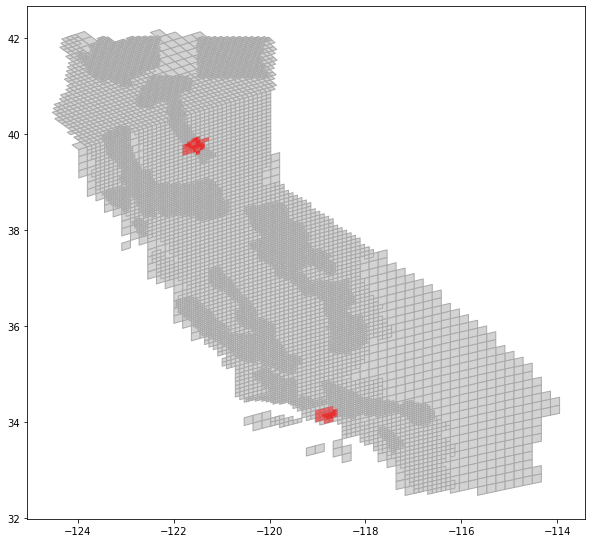

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
camp_preds_df[camp_preds_df.WF_WildFire==1].plot(ax=ax, color='red', legend=True, alpha=0.5)
plt.show()

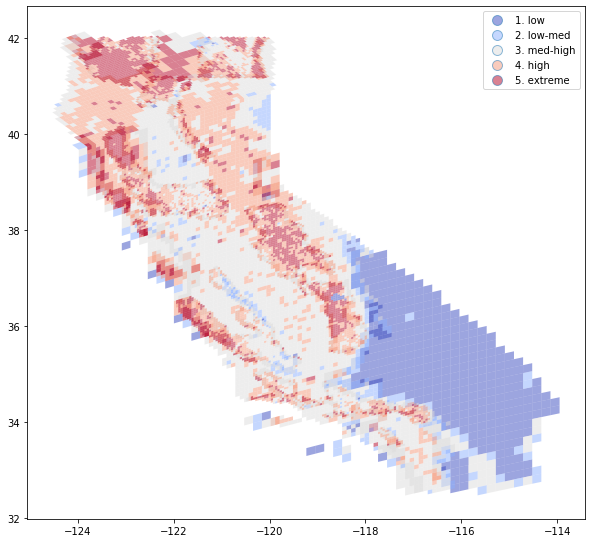

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
camp_preds_df.plot(ax=ax, column='precip70_cwEQ_ext_new_bins', cmap='coolwarm', legend=True, alpha=0.5)
plt.show()

## Ranch Fire (Mendocino Complex)

In [14]:
selected_date = '2018-07-27'
ranch_preds_df = ca_df.merge(ca_wf[ca_wf.WF_ALARM_DATE_DT_DT==selected_date][['S2_Cells_ID','WF_WildFire']], on='S2_Cells_ID', how='left')\
                   .merge(precip70_cwEQ_ext_new_probs[precip70_cwEQ_ext_new_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .fillna(0)
ranch_preds_df.shape

(10643, 12)

In [15]:
ranch_preds_df.WF_WildFire.sum()

154.0

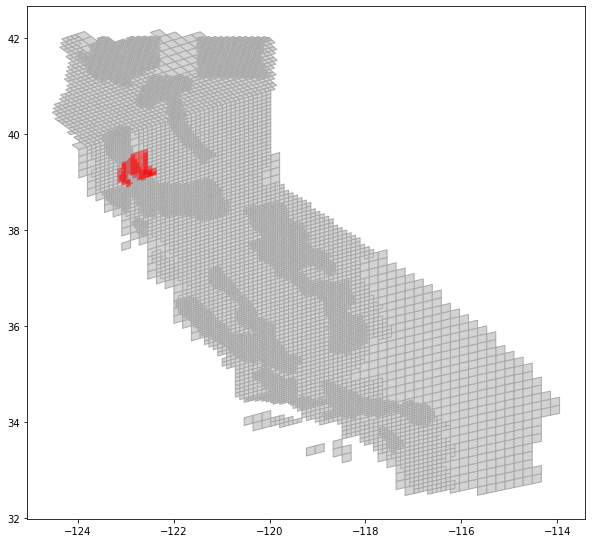

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
ranch_preds_df[ranch_preds_df.WF_WildFire==1].plot(ax=ax, color='red', legend=True, alpha=0.5)
plt.show()

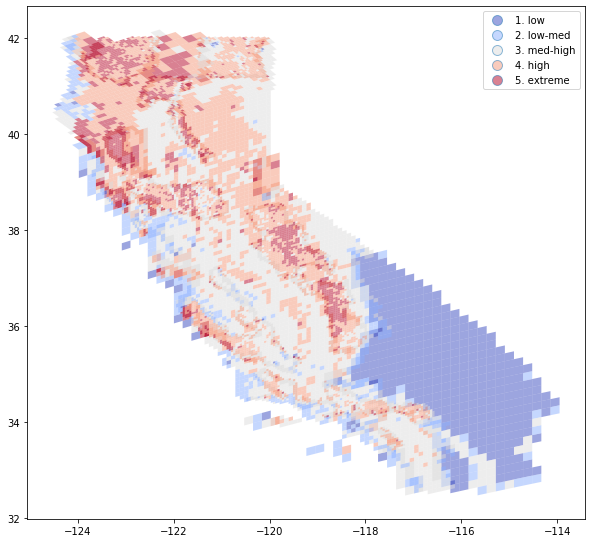

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ranch_preds_df.plot(ax=ax, column='precip70_cwEQ_ext_new_bins', cmap='coolwarm', legend=True, alpha=0.5)
plt.show()